<a href="https://colab.research.google.com/github/matthiaszeller/dl-project/blob/main/fully_dense_nn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
from torchvision import datasets
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader

import os

In [2]:
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz

--2021-03-03 19:24:54--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-03-03 19:24:54--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.2’

MNIST.tar.gz.2          [            <=>     ]  33.20M  14.0MB/s    in 2.4s    

2021-03-03 19:24:57 (14.0 MB/s) - ‘MNIST.tar.gz.2’ saved [34813078]



In [3]:
!tar -xf MNIST.tar.gz


In [4]:
!ls MNIST/processed/

test.pt  training.pt


In [5]:
######################################################################

def mnist_to_pairs(nb, input, target):
    input = torch.functional.F.avg_pool2d(input, kernel_size = 2)
    a = torch.randperm(input.size(0))
    a = a[:2 * nb].view(nb, 2)
    input = torch.cat((input[a[:, 0]], input[a[:, 1]]), 1)
    classes = target[a]
    target = (classes[:, 0] <= classes[:, 1]).long()
    return input, target, classes

######################################################################

def generate_pair_sets(nb):

    train_set = datasets.MNIST('', train = True, download = True)
    train_input = train_set.data.view(-1, 1, 28, 28).float()
    train_target = train_set.targets

    test_set = datasets.MNIST('', train = False, download = True)
    test_input = test_set.data.view(-1, 1, 28, 28).float()
    test_target = test_set.targets

    return mnist_to_pairs(nb, train_input, train_target) + \
           mnist_to_pairs(nb, test_input, test_target)

######################################################################

In [6]:
train_input , train_target , train_classes , test_input , test_target , test_classes = generate_pair_sets(1000)

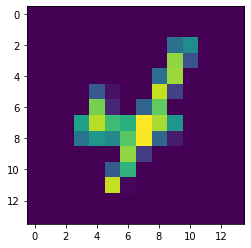

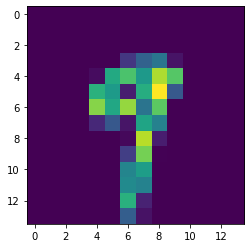

train shape : torch.Size([1000, 2, 14, 14])


In [7]:
plt.imshow( train_input[0][0].numpy() ) 
plt.show()
plt.imshow( train_input[0][1].numpy() ) 
plt.show()
print(f'train shape : {train_input.shape}')

In [8]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.fc1 = nn.Linear(2*14*14, 300)
        self.fc2 = nn.Linear(300, 200)
        self.fc3 = nn.Linear(200, 100)
        self.fc4 = nn.Linear(100, 50)
        self.fc5 = nn.Linear(50, 1)

    def forward(self, x):
        x = nn.Flatten(1)(x)
        x = torch.relu( self.fc1(x) )
        x = torch.relu( self.fc2(x) )
        x = torch.relu( self.fc3(x) )
        x = torch.relu( self.fc4(x) )
        x = self.fc5(x)
        return torch.sigmoid(x)

In [10]:
network = Net()
optimizer = optim.SGD(network.parameters(), lr=0.01,
                      momentum=0.5)

criterion = F.binary_cross_entropy

In [11]:
train_dataset = TensorDataset(train_input,train_target , train_classes)
train_dataloader = DataLoader(train_dataset , batch_size=100)

test_dataset = TensorDataset(test_input,test_target , test_classes)
test_dataloader = DataLoader(test_dataset , batch_size=100)


In [12]:
for el in train_dataloader:
  # image , target, classes
  print(el[0].shape, el[1].shape, el[2].shape)
  break

torch.Size([100, 2, 14, 14]) torch.Size([100]) torch.Size([100, 2])


In [13]:
def train(epoch_nb):
  network.train()
  for batch_idx, (data, target , classes ) in enumerate(train_dataloader):
    optimizer.zero_grad()
    output = network(data).flatten()
    loss = criterion(output, target.to(torch.float32))
    loss.backward()
    optimizer.step()
    if batch_idx % 1 == 0:
      print(f'Train Epoch: {epoch_nb} [{batch_idx}/{10}]\tLoss: {loss.item():.6f}')

In [14]:
def test():
  network.eval()
  test_loss = 0
  correct = 0

  with torch.no_grad():
    for data, target , classes in test_dataloader:
      output = network(data)
      test_loss += criterion(output.flatten(), target.to(torch.float32)).item()

  test_loss /= len(test_dataloader.dataset)
  print(f'\nTest set: Avg. loss: {test_loss:.4f}, Accuracy: {404}/{404} ({404:.0f}%)\n')

In [15]:
train(0)

Train Epoch: 0 [0/10]	Loss: 0.722753
Train Epoch: 0 [1/10]	Loss: 0.646707
Train Epoch: 0 [2/10]	Loss: 0.687954
Train Epoch: 0 [3/10]	Loss: 0.666599
Train Epoch: 0 [4/10]	Loss: 0.712706
Train Epoch: 0 [5/10]	Loss: 0.654952
Train Epoch: 0 [6/10]	Loss: 0.633044
Train Epoch: 0 [7/10]	Loss: 0.619216
Train Epoch: 0 [8/10]	Loss: 0.560704
Train Epoch: 0 [9/10]	Loss: 0.614066


In [16]:
test()
for epoch in range(25):
  train(epoch)
  test()


Test set: Avg. loss: 0.0057, Accuracy: 404/404 (404%)

Train Epoch: 0 [0/10]	Loss: 0.558873
Train Epoch: 0 [1/10]	Loss: 0.549951
Train Epoch: 0 [2/10]	Loss: 0.508659
Train Epoch: 0 [3/10]	Loss: 0.574624
Train Epoch: 0 [4/10]	Loss: 0.556352
Train Epoch: 0 [5/10]	Loss: 0.501542
Train Epoch: 0 [6/10]	Loss: 0.544714
Train Epoch: 0 [7/10]	Loss: 0.463029
Train Epoch: 0 [8/10]	Loss: 0.444488
Train Epoch: 0 [9/10]	Loss: 0.467870

Test set: Avg. loss: 0.0052, Accuracy: 404/404 (404%)

Train Epoch: 1 [0/10]	Loss: 0.510390
Train Epoch: 1 [1/10]	Loss: 0.456780
Train Epoch: 1 [2/10]	Loss: 0.432727
Train Epoch: 1 [3/10]	Loss: 0.525652
Train Epoch: 1 [4/10]	Loss: 0.466259
Train Epoch: 1 [5/10]	Loss: 0.425206
Train Epoch: 1 [6/10]	Loss: 0.453475
Train Epoch: 1 [7/10]	Loss: 0.395419
Train Epoch: 1 [8/10]	Loss: 0.346428
Train Epoch: 1 [9/10]	Loss: 0.419485

Test set: Avg. loss: 0.0061, Accuracy: 404/404 (404%)

Train Epoch: 2 [0/10]	Loss: 0.526765
Train Epoch: 2 [1/10]	Loss: 0.531911
Train Epoch: 2 [2/